### Loading Necessary Libraries

In [175]:
#from kats.models.prophet import ProphetModel, ProphetParams
#from kats.consts import TimeSeriesData
#from kats.models.var import VARModel, VARParams
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import os
import glob
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Read in Data

In [49]:
# read all files from a directory
path = r'/Users/edawg/Desktop/Duke/Time Series/Heart-Rate-Variability-Repo/01_data/1st topic'
rri_files = glob.glob(os.path.join(path, "*_RRI.txt"))
all_patients_df = pd.DataFrame()

for i in range(len(rri_files)):
    patient = rri_files[i].split("/")[-1][0:-8]
    bis_path = path + "/" + patient + "_BIS.txt"
    patient_num = i + 1

    # read in the data
    rri = pd.read_table(rri_files[i], sep=",",names=["time","signal"])
    bis = pd.read_table(bis_path, sep=",",names=["time","signal"])

    # rename signal column
    rri.rename(columns={"signal": "rri_" + str(patient_num)}, inplace=True)
    bis.rename(columns={"signal": "bis_" + str(patient_num)}, inplace=True)

    # merge the data
    patient_df = pd.concat([rri['rri_' + str(patient_num)], bis['bis_' + str(patient_num)]], axis=1)
    all_patients_df = pd.concat([all_patients_df, patient_df], axis=1)

all_patients_df['time'] = all_patients_df.index
all_patients_df['pre_post'] = np.where(all_patients_df['time']<all_patients_df['time'][1440],0,1)
all_patients_df

,rri_1,bis_1,rri_2,bis_2,rri_3,bis_3,rri_4,bis_4,rri_5,bis_5,...,rri_25,bis_25,rri_26,bis_26,rri_27,bis_27,rri_28,bis_28,time,pre_post
0,825.896112,56.164708,859.940135,43.098800,1055.712962,45.324064,656.771280,26.826689,964.467668,32.516983,...,731.866074,32.772420,844.174638,48.706720,1036.769300,37.528583,1104.571104,30.087002,0,0
1,825.899059,56.254664,858.098369,43.013895,1053.145867,45.194152,658.444182,26.801709,966.577226,32.432015,...,731.782331,32.817382,842.900578,48.786638,1040.097782,37.493595,1093.828273,30.111988,1,0
2,826.375276,56.344620,856.832234,42.928991,1049.441234,45.064240,660.013387,26.683644,967.880418,32.347048,...,730.477343,32.862344,844.835599,48.866557,1042.938552,37.458607,1084.926249,30.136973,2,0
3,827.648728,56.428813,856.646906,42.844087,1045.467821,44.934327,661.246011,26.558743,968.716328,32.262080,...,728.749676,32.907305,848.612716,48.946475,1043.992788,37.423619,1080.409352,30.161959,3,0
4,829.692027,56.503777,858.001085,42.759182,1042.094387,44.933087,661.966394,26.433842,969.476936,32.177112,...,727.435389,32.952267,852.054107,49.026393,1042.490969,37.388631,1081.227743,30.186945,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,739.525796,46.015123,953.255002,40.131617,852.841400,35.353787,636.117628,2.100000,762.074342,28.416510,...,871.426323,40.124091,1168.519256,57.236577,765.351208,29.514652,878.304499,33.118502,3836,1
3837,738.431676,46.025118,958.937697,40.011752,853.109321,35.378770,636.779477,2.100000,762.639833,28.411512,...,875.308250,40.049155,1167.405411,57.466343,764.515831,29.479664,883.227917,33.008565,3837,1
3838,737.117124,46.035113,961.489002,39.891887,853.377243,35.403753,637.647817,2.100000,763.976446,28.406514,...,878.991623,39.974219,1166.291567,57.562392,757.284474,29.444676,886.297960,32.898627,3838,1
3839,735.944230,46.045108,962.656826,39.772022,853.645164,35.428737,638.777592,2.100000,766.311931,28.401516,...,879.795025,39.899283,1165.177722,57.472484,748.945789,29.409688,887.585408,32.788690,3839,1


### Data Exploration

In [72]:
rris = all_patients_df[[col for col in all_patients_df if col.startswith('rri')]].copy()
rris['time'] = all_patients_df['time']
bis_all = all_patients_df[[col for col in all_patients_df if col.startswith('bis')]].copy()
bis_all['time'] = all_patients_df['time']

Plotting RRI data for all 28 patients

In [78]:
rris['rri_9'].isnull().sum()

0

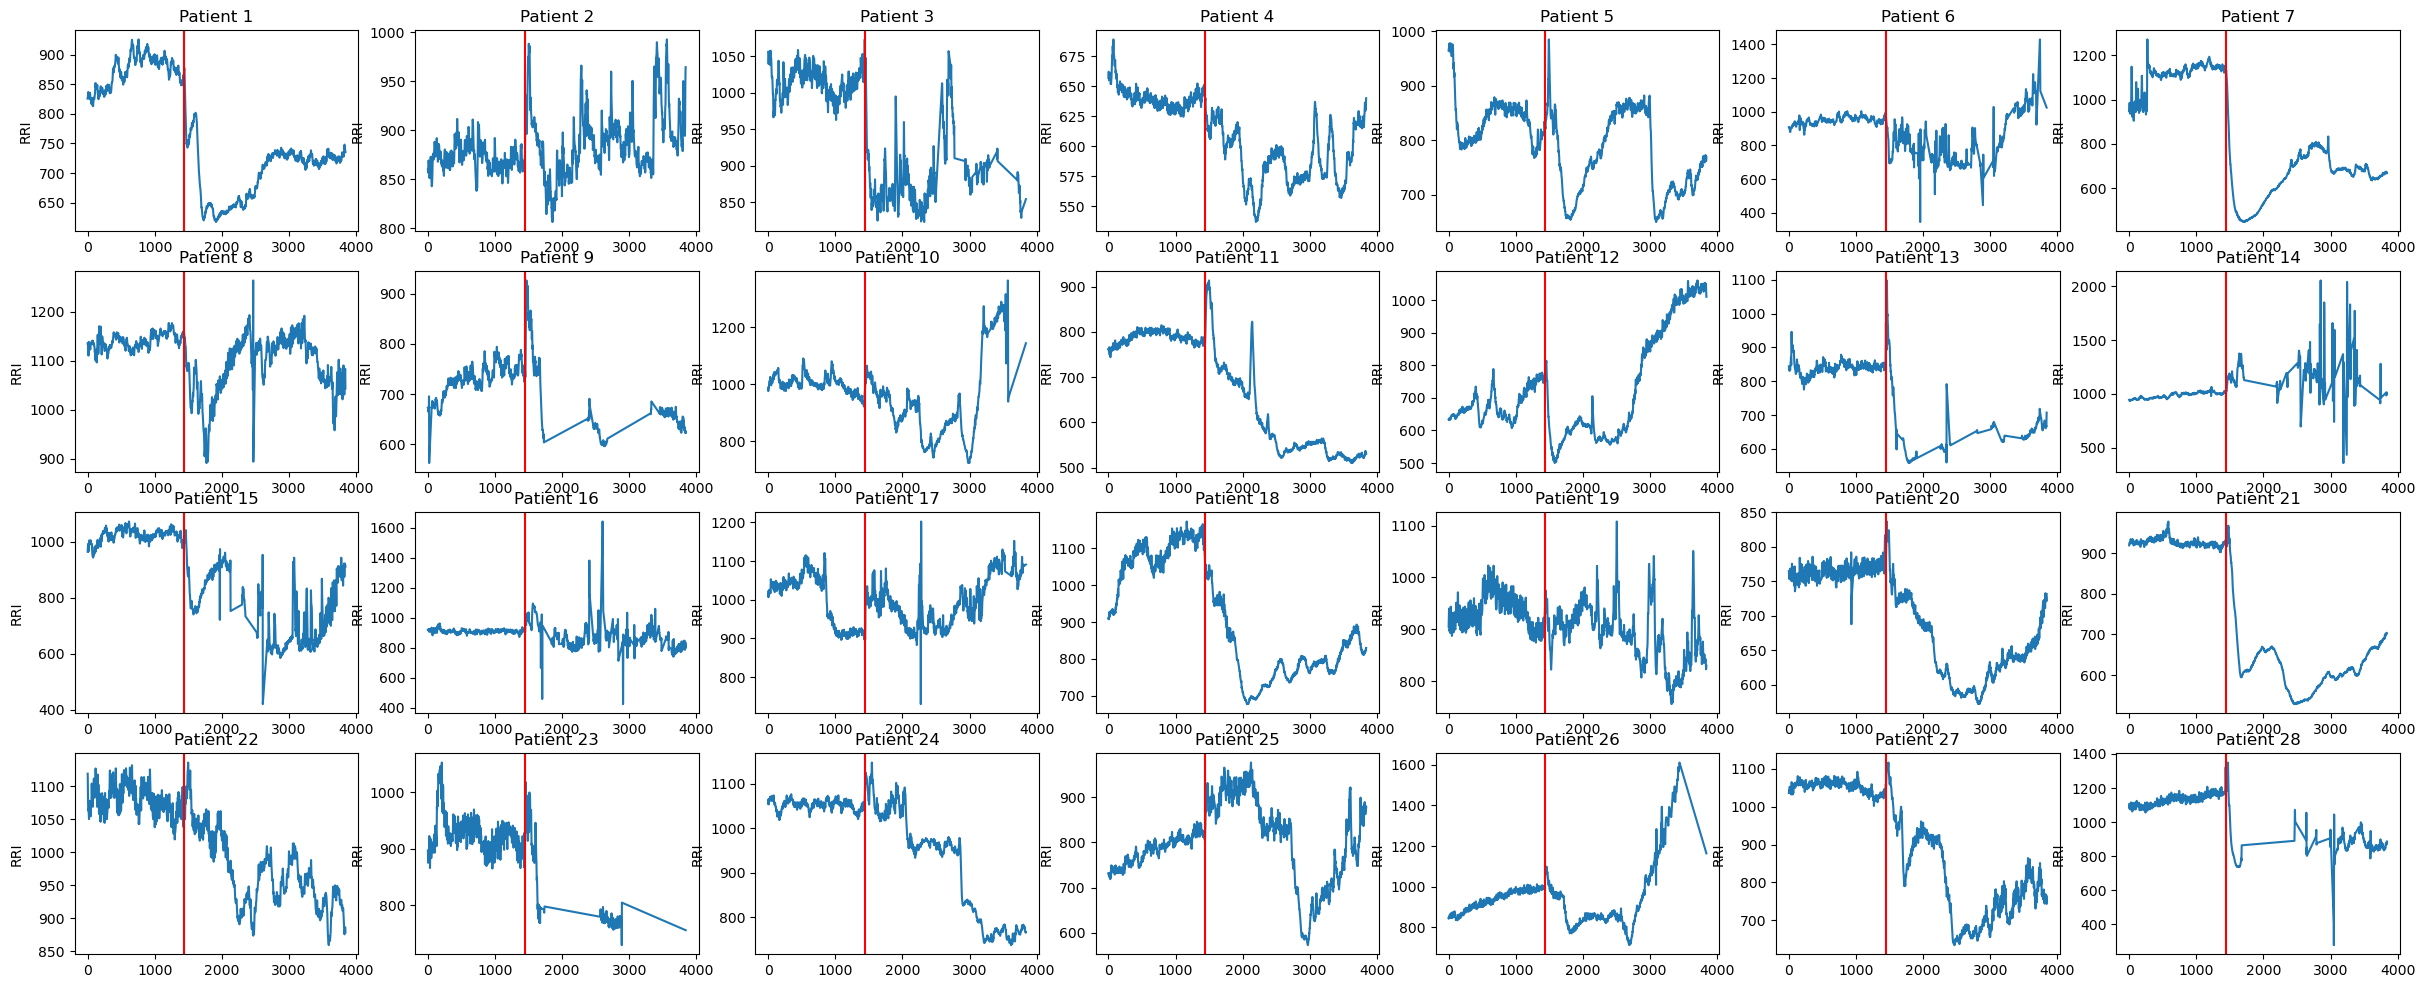

In [73]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

Plotting BIS data for all 28 patients:

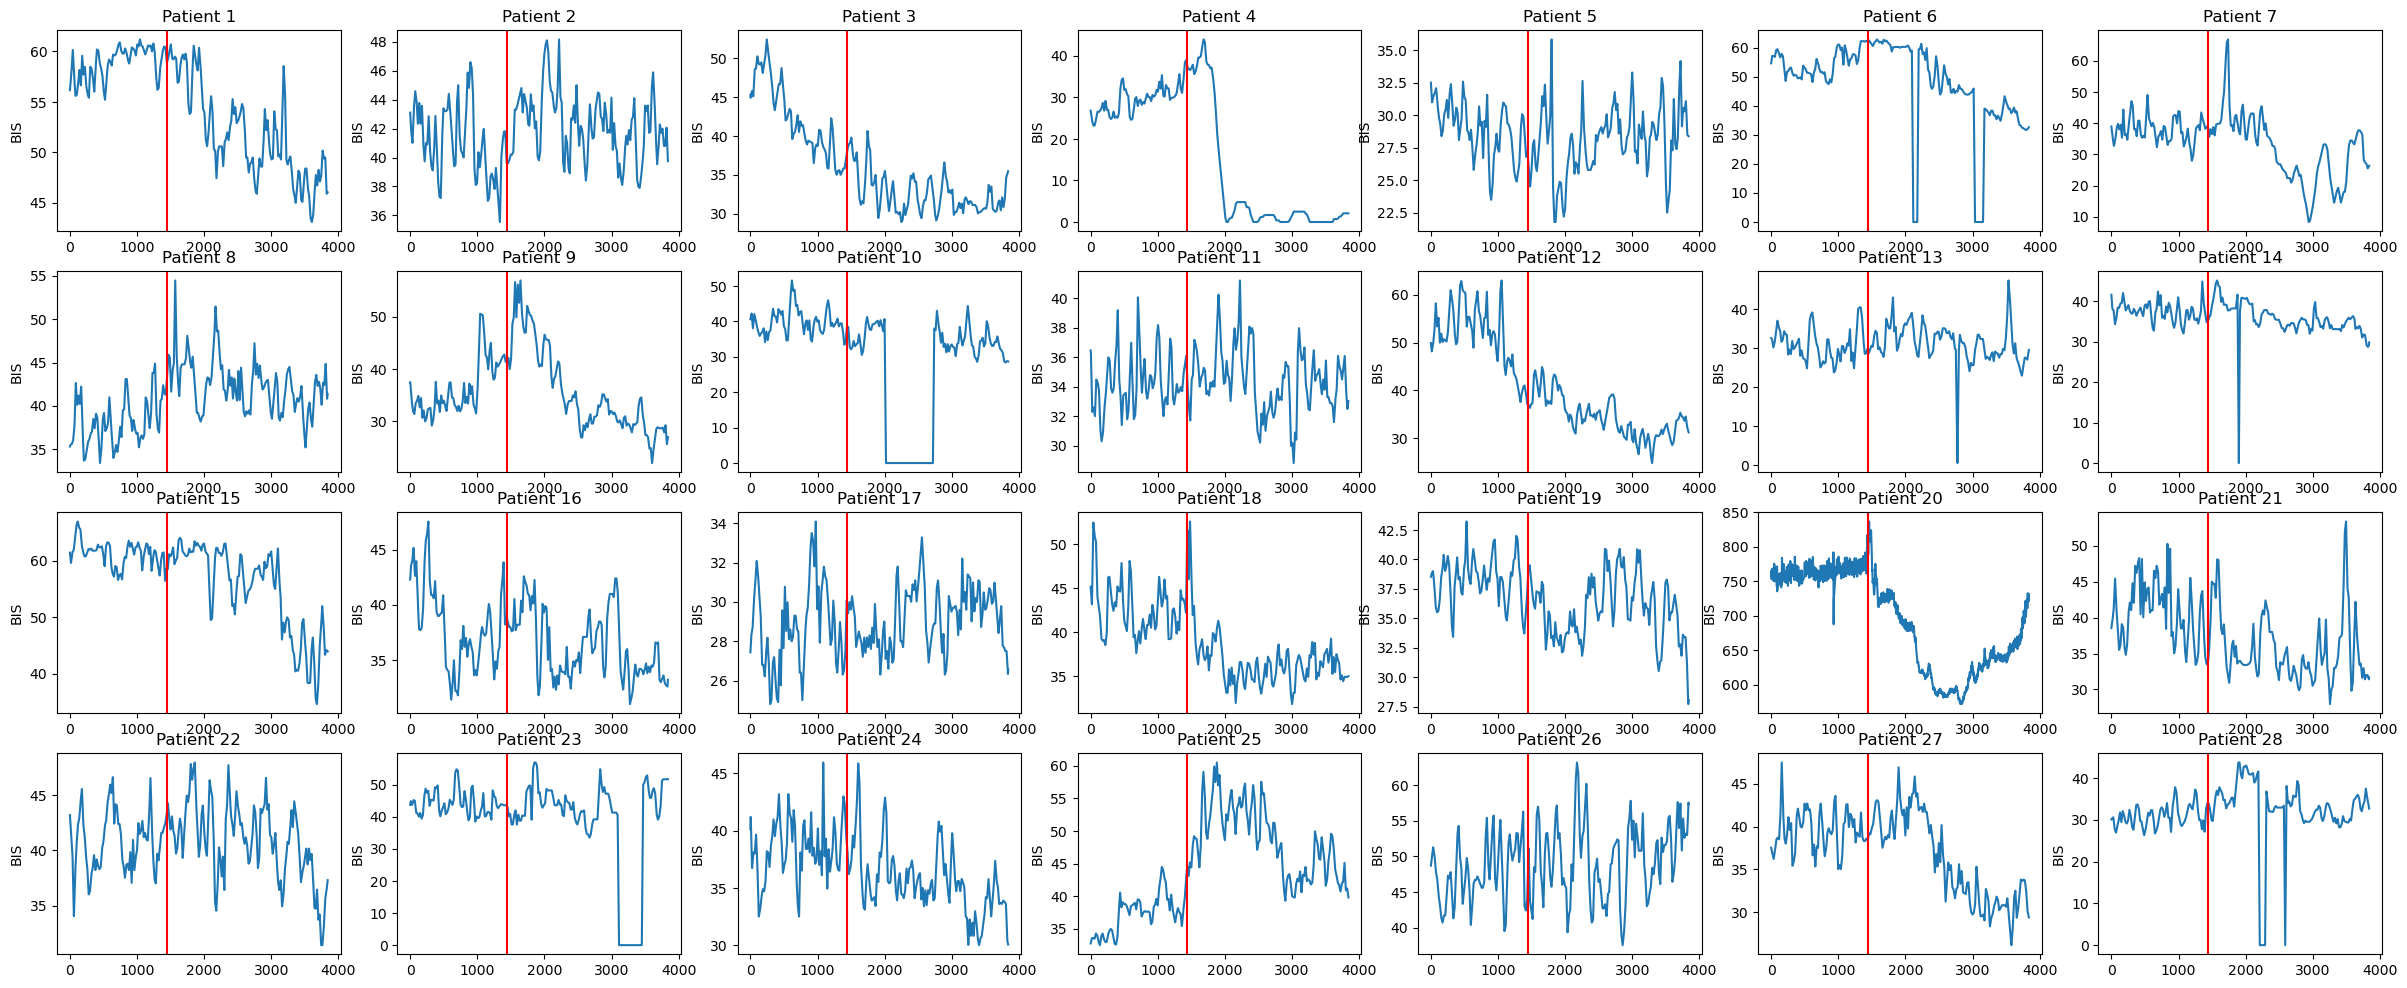

In [75]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(bis_all['time'], bis_all["bis_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('BIS')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

In [70]:
#calculate ADFs for each
# calculate mean times

### Data Preprocessing

1) If we don't have any 0s in the RRI data how do we identify missing data?

- Differencing
- Smoothing
- SST?? What does this do??
- What to do with huge jumps?
- imputing [x] done

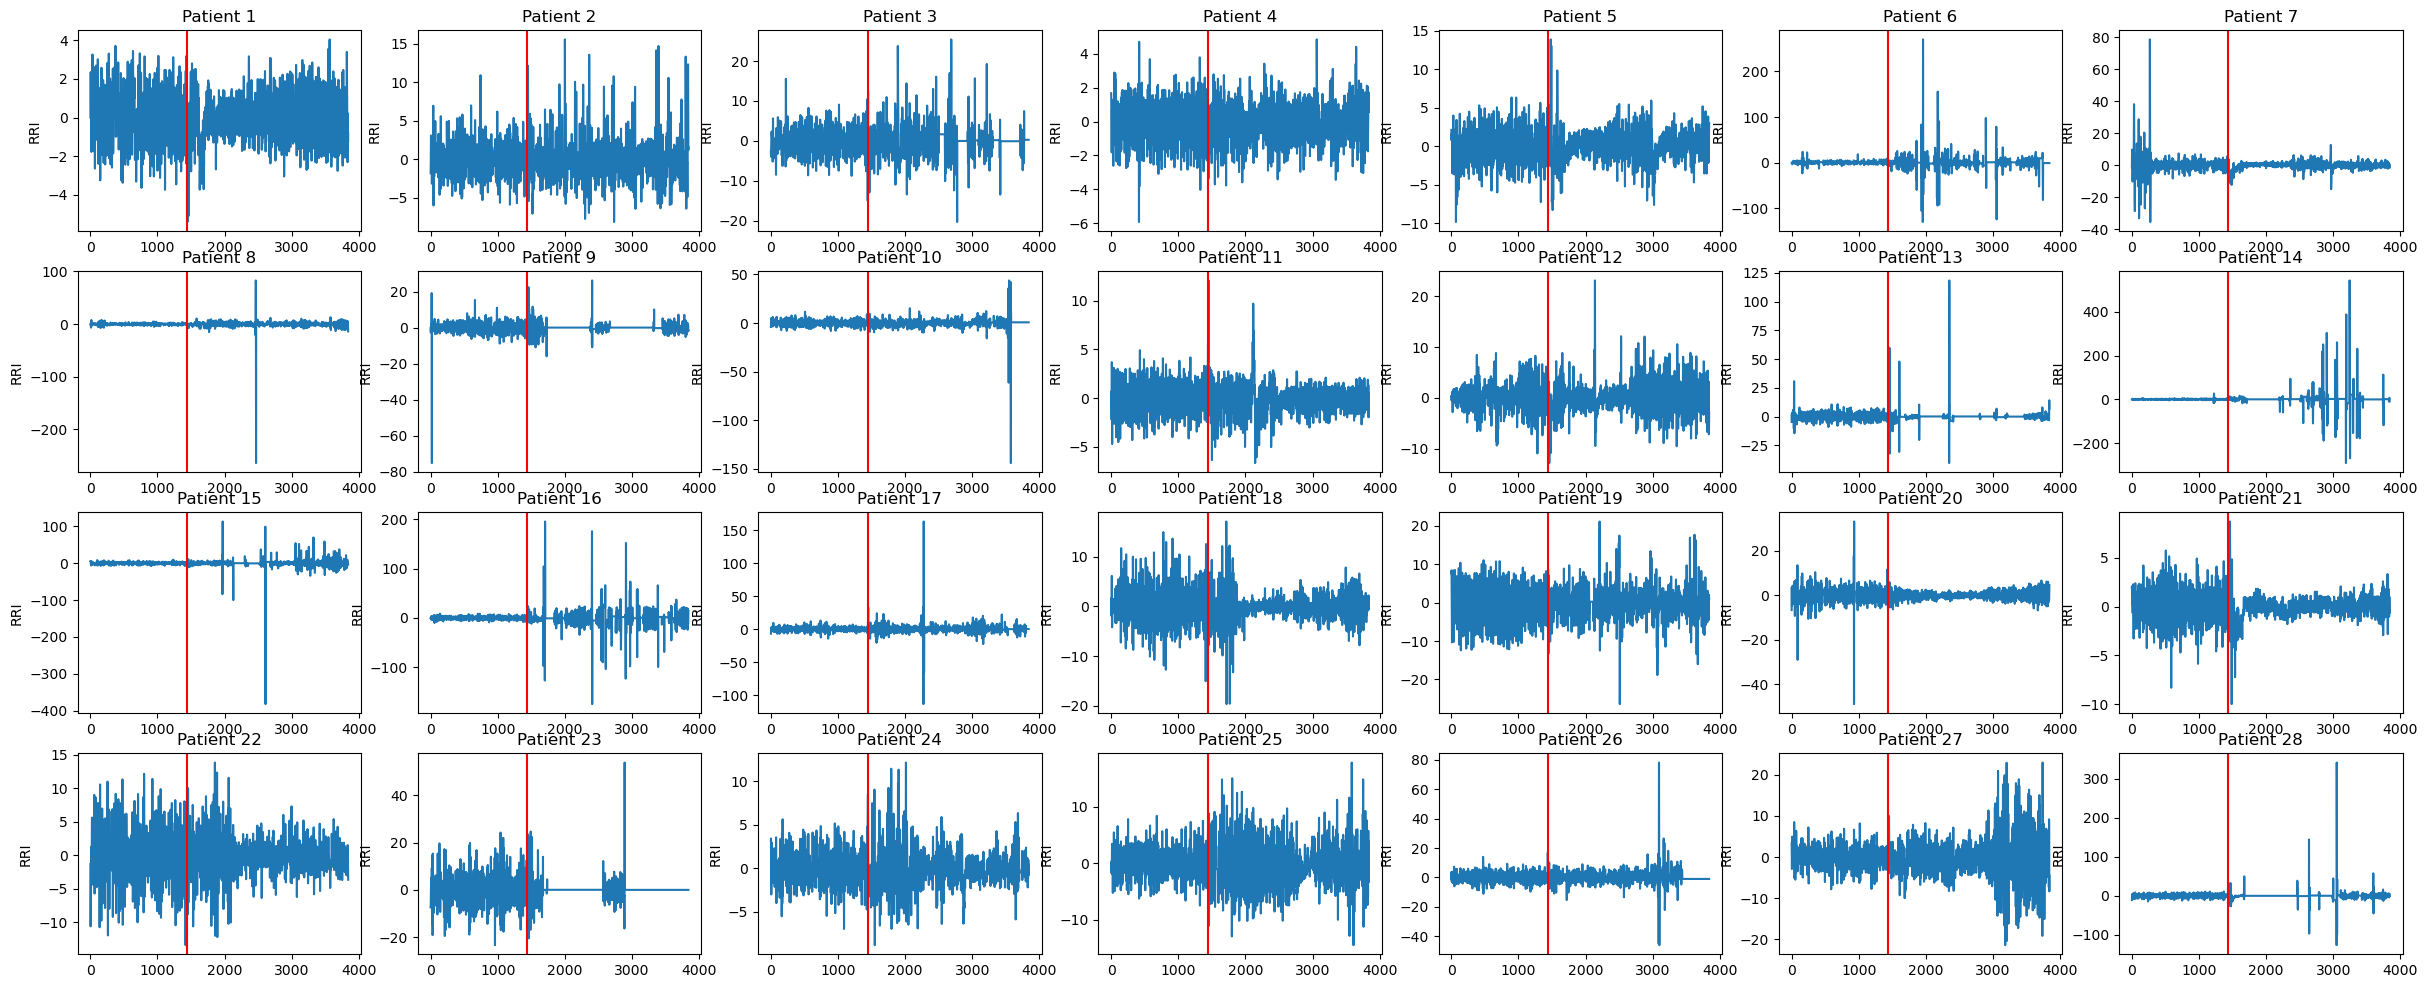

In [119]:
# plot the differences

fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)].diff(periods = 1))
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')


In [134]:
# performing stationarity checks after differencing
patients = []
p_values = []
periods = 1
for patient in range(len(rris.columns) - 1):
    patients.append(patient + 1)
    p_values.append(adfuller(rris.iloc[:,patient].diff(periods = periods).dropna())[1])
stationarity_checks = pd.DataFrame({'patient': patients, 'p-value': p_values})
stationarity_checks['is_stationary'] = np.where(stationarity_checks['p-value'] < 0.05, 1, 0)
print(stationarity_checks['is_stationary'].sum(), ' out of', len(stationarity_checks), ' patients are stationary', "(" + str(round(stationarity_checks['is_stationary'].sum()/len(stationarity_checks)*100, 2)) + "%)")

28  out of 28  patients are stationary (100.0%)


In [138]:
# create a dataset with differenced rris
def differenced_rris(rris, periods):
    rris_diff = pd.DataFrame()
    for patient in range(len(rris.columns) - 1):
        rris_diff['rri_' + str(patient + 1)] = rris.iloc[:,patient].diff(periods = periods).dropna()
    return rris_diff

rris_diff = differenced_rris(rris, periods = 1)

In [147]:
rris_diff.to_csv("rris_diff.csv", index = False)

In [148]:
rris.drop("time", axis = 1, inplace = False).to_csv("rris.csv", index = False)

### GARCH Model Fitting

In [247]:
test_size = 1000
diff = False
patient_num = 7
if diff:
    train, test = rris_diff['rri_' + str(patient_num)][:len(rris_diff['rri_' + str(patient_num)]) - test_size], rris_diff['rri_' + str(patient_num)][len(rris_diff['rri_' + str(patient_num)]) - test_size:]
else:
    train, test = rris['rri_' + str(patient_num)][:len(rris['rri_' + str(patient_num)]) - test_size], rris['rri_' + str(patient_num)][len(rris['rri_' + str(patient_num)]) - test_size:]
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1).fit()
model.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 87432.56224357424
Iteration:      2,   Func. Count:     11,   Neg. LLF: 23114.6952008331
Iteration:      3,   Func. Count:     15,   Neg. LLF: 23114.65949776411
Iteration:      4,   Func. Count:     19,   Neg. LLF: 23114.52116872624
Iteration:      5,   Func. Count:     23,   Neg. LLF: 23114.393567539606
Iteration:      6,   Func. Count:     27,   Neg. LLF: 23114.393359956684
Iteration:      7,   Func. Count:     30,   Neg. LLF: 23114.393359968577
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23114.393359956684
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 7


/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.883e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  rri_7   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23114.4
Distribution:                  Normal   AIC:                           46234.8
Method:            Maximum Likelihood   BIC:                           46252.6
                                        No. Observations:                 2841
Date:                Sat, Apr 08 2023   Df Residuals:                     2841
Time:                        16:24:39   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.6526e+04   1913.989      8.634  5.914e-18 [1.277e+04,2.028e+04]
alpha[1]       0.9703  6.136e-02     15.813  2.514e-56     [  0.850,  1.091]
beta[1]        0.0000  6.498e-02      0.000      1.000     [ -0.127,  0.127]
============================================================================

Covariance estimator: robust
"""

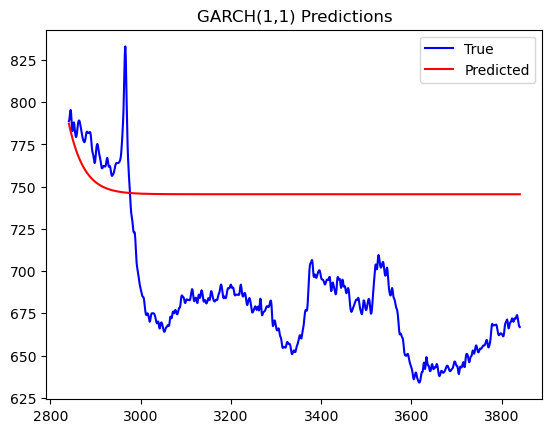

In [248]:
predictions = model.forecast(horizon = test_size, reindex = False)
true = plt.plot(test, color='blue', label='True')
pred = plt.plot(test.index, np.sqrt(predictions.variance.values[-1,:]), color='red', label='Predicted')
plt.title('GARCH(1,1) Predictions')
plt.legend()
plt.show()

### GARCH Rolling Forecasts

Method for creating rolling density forecast from ARMA-GARCH models with option for refitting every n periods with parallel functionality.

In [275]:
# Rolling Forecast
rolling_predictions = []
window = 5
for i in range(0, test_size, window):
    if diff:
        train = rris_diff['rri_' + str(patient_num)][:len(rris_diff['rri_' + str(patient_num)]) - test_size + i]
    else:
        train = rris['rri_' + str(patient_num)][:-(test_size - i)]
    model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1).fit(disp='off')
    pred = model.forecast(horizon = window, reindex = False)
    rolling_predictions.append((np.sqrt(pred.variance.values[-1,:])))

/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.883e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.872e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/edawg/opt/miniconda3/lib/python3.10/site-

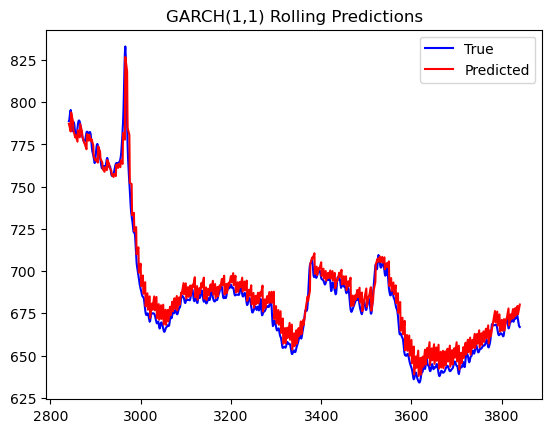

In [276]:
true, = plt.plot(test, color='blue', label='True')
rolling_predictions = np.reshape(rolling_predictions, (1, -1))[0]
pred, = plt.plot(test.index, rolling_predictions, color='red', label='Predicted')
plt.title('GARCH(1,1) Rolling Predictions')
plt.legend()
plt.show()

### Hyperparameter Tuning

Questions

1) Confirm VAR models. Do we fit multiple observations of the same variable or different variables for the same observation?
2) We're seeing a flat line for our predictions for both VARMA and GARCH model. Any tips on how to better our models?
3) Would rolling predictions be helpful in our situation?